In [1]:
%matplotlib inline

In [2]:
import glob
import gzip
import StringIO

import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy
import us

# create a list of all U.S. states
states = [state.abbr for state in us.states.STATES]

In [199]:
def download_qwi_data(path, states, char, fas, geo, ind, own, sa):
    """Download the Quarterly Workforce Indicators (QWI) data given some query params."""
    for st in states:
        tmp_url = qwi_url(st, char, fas, geo, ind, own, sa)
        tmp_buffer = requests.get(tmp_url)
        tmp_buffer.raise_for_status()

        tmp_file_name = qwi_file_name(st, char, fas, geo, ind, own, sa)
        with open(path + tmp_file_name, 'wb') as tmp_gzip_file:
            tmp_gzip_file.write(tmp_buffer.content)
            
        print("Done with QWI data for {}!".format(st))

In [212]:
download_qwi_data("./data/", states[43:], 'se', 'f', 'gc', 'n4', 'oslp', 'u')

Done with QWI data for TX!
Done with QWI data for UT!
Done with QWI data for VT!
Done with QWI data for VA!
Done with QWI data for WA!
Done with QWI data for WV!
Done with QWI data for WI!
Done with QWI data for WY!


In [220]:
def qwi_file_name(st, char, fas, geo, ind, own, sa):
    """Return the QWI file name given some query parameters."""
    file_name = ('qwi_' + st.lower() + '_' + char + '_' + fas + '_' + geo + 
                 '_' + ind + '_' + own + '_' + sa + '.csv.gz')
    return file_name


def qwi_url(st, char, fas, geo, ind, own, sa):
    """Return a QWI file path given some query parameters."""
    base_url = 'http://lehd.ces.census.gov/pub/'
    file_path = st.lower() + '/latest_release/DVD-' + char + '_' + fas + "/"
    file_name = qwi_file_name(st, char, fas, geo, ind, own, sa)
    url = base_url + file_path + file_name
    return url


def qwi_release_to_dataframes(filepath_or_buffer, **kwargs): 
    """Chunks a compressed QWI release file or buffer into an dataframe iterator."""
    dfs = pd.read_csv(filepath_or_buffer , **kwargs)
    return dfs


def qwi_dataframes_to_sql(dataframes, table, engine, mesg=False):
    """Dumps contents of dataframes into an SQL table."""
    chunks = 0
    for dataframe in dataframes:
        dataframe.to_sql(table, engine, if_exists='append')
        chunks += 1
        
        if mesg:
            records = chunks * dataframes.chunksize
            print("Completed {} records...".format(records))
    

In [221]:
def release_base_url(year, quarter, state, workers, firms):
    """Return the base url for the desired QWI data release."""
    host = 'http://lehd.ces.census.gov/'
    path = ('php/inc_download.php?s=' + state.lower() + '&f=/R' + 
            str(year) + 'Q' + str(quarter) + '/DVD-' + workers + '_' + firms + "/")
    return host + path


def release_file_name(state, workers, firms, geography, industry,
                      ownership, season_adjustments):
    """Return the file name for the desired QWI data release."""
    file_name = ('qwi_' + state.lower() + '_' + workers + '_' + firms + 
                 '_' + geography + '_' + industry + '_' + ownership + 
                 '_' + season_adjustments + '.csv.gz')
    return file_name


def release_url(year, quarter, state, workers, firms, geography,
                industry, ownership, season_adjustments):
    """Return the url for the desired QWI data release."""
    tmp_base_url = release_base_url(year, quarter, state, workers, firms)
    tmp_file_name = release_file_name(state, workers, firms, geography,
                                      industry, ownership, season_adjustments)
    return tmp_base_url + tmp_file_name
    
     


# TODO

1. Identify unecessary columns and drop them from data base...
2. Add a multicolumn primary key...
3. Skip headers...
4. Loop over the files in sh script explictly...

In [251]:
import glob

In [292]:
cd data/

/Users/drpugh/Research/python-dev/pyAM/examples/data


In [309]:
# create a sqlite database in working directory...
test_engine = sqlalchemy.create_engine('sqlite:///test.sqlite')

In [310]:
creation = """CREATE TABLE qwi (
                    periodicity   TEXT,     -- Periodicity of report
                    seasonadj     TEXT,     -- Seasonal Adjustment Indicator
                    geo_level     TEXT,     -- Group: Geographic level of aggregation
                    geography     TEXT,     -- Group: Geography code
                    ind_level     TEXT,     -- Group: Industry level of aggregation
                    industry      TEXT,     -- Group: Industry code
                    ownercode     TEXT,     -- Group: Ownership group code
                    sex           TEXT,     -- Group: Gender code
                    agegrp        TEXT,     -- Group: Age group code (WIA)
                    race          TEXT,     -- Group: race
                    ethnicity     TEXT,     -- Group: ethnicity
                    education     TEXT,     -- Group: education
                    firmage       TEXT,     -- Group: Firm Age group
                    firmsize      TEXT,     -- Group: Firm Size group
                    year          INTEGER,  -- Time: Year
                    quarter       INTEGER,  -- Time: Quarter
                    Emp           INTEGER,  -- Employment: Counts
                    EmpEnd        INTEGER,  -- Employment end-of-quarter: Counts
                    EmpS          INTEGER,  -- Employment stable jobs: Counts
                    EmpTotal      INTEGER,  -- Employment reference quarter: Counts
                    EmpSpv        INTEGER,  -- Employment stable jobs - previous quarter: Counts
                    HirA          INTEGER,  -- Hires All: Counts
                    HirN          INTEGER,  -- Hires New: Counts
                    HirR          INTEGER,  -- Hires Recalls: Counts
                    Sep           INTEGER,  -- Separations: Counts
                    HirAEnd       INTEGER,  -- End-of-quarter hires
                    SepBeg        INTEGER,  -- Beginning-of-quarter separations
                    HirAEndRepl   INTEGER,  -- Replacement hires
                    HirAEndR      REAL,     -- End-of-quarter hiring rate
                    SepBegR       REAL,     -- Beginning-of-quarter separation rate
                    HirAEndReplR  REAL,     -- Replacement hiring rate
                    HirAS         INTEGER,  -- Hires All stable jobs: Counts
                    HirNS         INTEGER,  -- Hires New stable jobs: Counts
                    SepS          INTEGER,  -- Separations stable jobs: Counts
                    SepSnx        INTEGER,  -- Separations stable jobs - next quarter: Counts
                    TurnOvrS      REAL,     -- Turnover stable jobs: Ratio
                    FrmJbGn       INTEGER,  -- Firm Job Gains: Counts
                    FrmJbLs       INTEGER,  -- Firm Job Loss: Counts
                    FrmJbC        INTEGER,  -- Firm jobs change: Net Change
                    FrmJbGnS      INTEGER,  -- Firm Gain stable jobs: Counts
                    FrmJbLsS      INTEGER,  -- Firm Loss stable jobs: Counts
                    FrmJbCS       INTEGER,  -- Firm stable jobs change: Net Change
                    EarnS         REAL,     -- Employees stable jobs: Average monthly earnings
                    EarnBeg       REAL,     -- Employees beginning-of-quarter : Average monthly earnings
                    EarnHirAS     REAL,     -- Hires All stable jobs: Average monthly earnings
                    EarnHirNS     REAL,     -- Hires New stable jobs: Average monthly earnings
                    EarnSepS      REAL,     -- Separations stable jobs: Average monthly earnings
                    Payroll       INTEGER,  -- Total quarterly payroll: Sum
                    sEmp          INTEGER,  -- Status: Employment: Counts
                    sEmpEnd       INTEGER,  -- Status: Employment end-of-quarter: Counts
                    sEmpS         INTEGER,  -- Status: Employment stable jobs: Counts
                    sEmpTotal     INTEGER,  -- Status: Employment reference quarter: Counts
                    sEmpSpv       INTEGER,  -- Status: Employment stable jobs - previous quarter: Counts
                    sHirA         INTEGER,  -- Status: Hires All: Counts
                    sHirN         INTEGER,  -- Status: Hires New: Counts
                    sHirR         INTEGER,  -- Status: Hires Recalls: Counts
                    sSep          INTEGER,  -- Status: Separations: Counts
                    sHirAEnd      INTEGER,  -- Status: End-of-quarter hires
                    sSepBeg       INTEGER,  -- Status: Beginning-of-quarter separations
                    sHirAEndRepl  INTEGER,  -- Status: Replacement hires
                    sHirAEndR     INTEGER,  -- Status: End-of-quarter hiring rate
                    sSepBegR      INTEGER,  -- Status: Beginning-of-quarter separation rate
                    sHirAEndReplR INTEGER,  -- Status: Replacement hiring rate
                    sHirAS        INTEGER,  -- Status: Hires All stable jobs: Counts
                    sHirNS        INTEGER,  -- Status: Hires New stable jobs: Counts
                    sSepS         INTEGER,  -- Status: Separations stable jobs: Counts
                    sSepSnx       INTEGER,  -- Status: Separations stable jobs - next quarter: Counts
                    sTurnOvrS     INTEGER,  -- Status: Turnover stable jobs: Ratio
                    sFrmJbGn      INTEGER,  -- Status: Firm Job Gains: Counts
                    sFrmJbLs      INTEGER,  -- Status: Firm Job Loss: Counts
                    sFrmJbC       INTEGER,  -- Status: Firm jobs change: Net Change
                    sFrmJbGnS     INTEGER,  -- Status: Firm Gain stable jobs: Counts
                    sFrmJbLsS     INTEGER,  -- Status: Firm Loss stable jobs: Counts
                    sFrmJbCS      INTEGER,  -- Status: Firm stable jobs change: Net Change
                    sEarnS        INTEGER,  -- Status: Employees stable jobs: Average monthly earnings
                    sEarnBeg      INTEGER,  -- Status: Employees beginning-of-quarter : Average monthly earnings
                    sEarnHirAS    INTEGER,  -- Status: Hires All stable jobs: Average monthly earnings
                    sEarnHirNS    INTEGER,  -- Status: Hires New stable jobs: Average monthly earnings
                    sEarnSepS     INTEGER,  -- Status: Separations stable jobs: Average monthly earnings
                    sPayroll      INTEGER  -- Status: Total quarterly payroll: Sum
                );"""

In [311]:
test_engine.execute(creation)

In [282]:
query

'SELECT *\n           FROM qwi \n           WHERE (year = 2014 AND quarter = 1)\n           AND geo_level = "C"\n           AND ind_level=4\n           AND (industry BETWEEN 5500 AND 5599)\n           AND sex = 0\n           AND education = \'E0\'\n           AND (sEMP = 1 AND sPayroll = 1);'

In [16]:
# create a sqlite database in working directory...
disk_engine = sqlalchemy.create_engine('sqlite:///qwi.sqlite')

In [253]:
import glob

# create a sqlite database in working directory...
disk_engine = sqlalchemy.create_engine('sqlite:///qwi.sqlite')

# grab the data files...
data_files = glob.glob('./data/*.gz')

for data_file in data_files:
    
    # load the data into Pandas...
    dfs = qwi_release_to_dataframes(data_file,
                                    chunksize=100000,
                                    iterator=True,
                                    compression='gzip',
                                    engine='c',
                                    )

    # ...write out to the SQL database!
    qwi_dataframes_to_sql(dfs, 'qwi', disk_engine, mesg=True)
    
    print("\nDone with {}!\n".format(data_file))

Completed 100000 records...
Completed 200000 records...
Completed 300000 records...
Completed 400000 records...
Completed 500000 records...
Completed 600000 records...
Completed 700000 records...
Completed 800000 records...
Completed 900000 records...
Completed 1000000 records...
Completed 1100000 records...
Completed 1200000 records...
Completed 1300000 records...
Completed 1400000 records...
Completed 1500000 records...
Completed 1600000 records...
Completed 1700000 records...
Completed 1800000 records...
Completed 1900000 records...
Completed 2000000 records...
Completed 2100000 records...
Completed 2200000 records...
Completed 2300000 records...
Completed 2400000 records...
Completed 2500000 records...
Completed 2600000 records...
Completed 2700000 records...
Completed 2800000 records...
Completed 2900000 records...
Completed 3000000 records...
Completed 3100000 records...

Done with ./data/qwi_ak_se_f_gc_n4_oslp_u.csv.gz!

Completed 100000 records...
Completed 200000 records...
Co

KeyboardInterrupt: 

In [163]:
tmp_url = qwi_url("VA", "se", "f", "gc", "n4", "oslp", "u")
connection = requests.get(tmp_url)
tmp_file = StringIO.StringIO(connection.content)
    
dfs = qwi_release_to_dataframes(tmp_file)
qwi_dataframes_to_sql(dfs, 'qwi', disk_engine, mesg=True)

# don't forget to close connections!
tmp_file.close()
connection.close()
    
print("Done with {}!".format(state))

Completed 100000 records...
Completed 200000 records...
Completed 300000 records...
Completed 400000 records...
Completed 500000 records...
Completed 600000 records...
Completed 700000 records...
Completed 800000 records...
Completed 900000 records...
Completed 1000000 records...
Completed 1100000 records...
Completed 1200000 records...
Completed 1300000 records...
Completed 1400000 records...
Completed 1500000 records...
Completed 1600000 records...
Completed 1700000 records...
Completed 1800000 records...
Completed 1900000 records...
Completed 2000000 records...
Completed 2100000 records...
Completed 2200000 records...
Completed 2300000 records...
Completed 2400000 records...
Completed 2500000 records...
Completed 2600000 records...
Completed 2700000 records...
Completed 2800000 records...
Completed 2900000 records...
Completed 3000000 records...
Completed 3100000 records...
Completed 3200000 records...
Completed 3300000 records...
Completed 3400000 records...
Completed 3500000 recor

In [19]:
query = """SELECT *
           FROM qwi 
           WHERE (year = 2014 AND quarter = 1)
           AND geo_level = "C"
           AND sex = 0
           AND education = 'E0'
           AND (sEMP = 1 AND sPayroll = 1);"""
df = pd.read_sql_query(query, disk_engine)

count     143217
unique         1
top            0
freq      143217
Name: firmage, dtype: object

In [32]:
tmp = df[(df.industry >= "3200") & (df.industry < "3400")]

In [92]:
from scipy import stats

In [113]:
stats.moment(tmp[tmp.Emp > 0].Emp)

0.0

In [115]:
tmp[tmp.Emp > 0].Emp

TypeError: cannot convert the series to <type 'float'>

In [97]:
tmp[tmp.Emp > 0].Emp.describe()

count     8886.000000
mean       470.636957
std       1367.183490
min          3.000000
25%         53.000000
50%        158.000000
75%        432.000000
max      44630.000000
Name: Emp, dtype: float64

In [111]:
pd.stats.moments.expanding_kurt?

In [18]:
pd.read_sql_query("SELECT DISTINCT ownercode FROM qwi", disk_engine)

,ownercode
0,A00
1,A05


In [8]:
def emprical_cdf(series):
    sq = series.value_counts()
    cdf = sq.sort_index().cumsum() * (1.0 / series.count())
    return cdf

def empirical_sf(series):
    return 1 - emprical_cdf(series)


In [9]:
def freedman_diaconis_rule(series):
    iqr = series.quantile(0.75) - series.quantile(0.25)
    h = 2.0 * iqr * series.count()**-0.33
    return round((series.max() - series.min()) / h, 0)

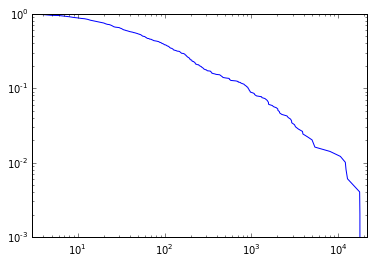

In [10]:
fig, ax = plt.subplots(1, 1)
#transportation_warehousing.plot(loglog=True, ax=ax)
#finance.plot(loglog=True, ax=ax)
empirical_sf(df[df.Emp > 0].Emp).plot(loglog=True, ax=ax)
plt.show()

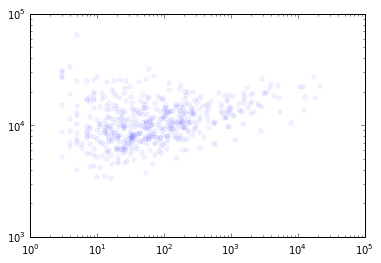

In [11]:
plt.scatter(df[df.Emp > 0].Emp, (df[df.Emp > 0].Payroll / df[df.Emp > 0].Emp), edgecolor='b', alpha=0.05)
plt.xscale('log')
plt.yscale('log')

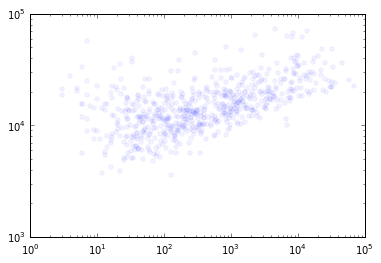

In [11]:
plt.scatter(df[df.Emp > 0].Emp, (df[df.Emp > 0].Payroll / df[df.Emp > 0].Emp), edgecolor='b', alpha=0.05)
plt.xscale('log')
plt.yscale('log')

In [170]:
df[df.Emp > 0].count()

Emp        1992
Payroll    1992
dtype: int64

In [125]:
df.EarnS.describe()

count     0
unique    0
Name: EarnS, dtype: int64

In [258]:
plt.scatter(df[df.Emp > 0].Emp, (df[df.Emp > 0].EarnS))
plt.xscale('log')
plt.yscale('log')

AttributeError: 'DataFrame' object has no attribute 'EarnS'

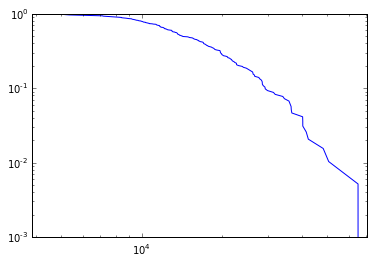

In [259]:
empirical_sf((df.Payroll / df.Emp)[df.Emp > 0]).plot(loglog=True)

In [78]:
df.Emp[df.sEmp == 1].describe()

count      460.000000
mean       475.484783
std       2433.996251
min          0.000000
25%         18.000000
50%         54.000000
75%        166.250000
max      37510.000000
Name: Emp, dtype: float64

In [261]:
df.columns

Index([u'Emp', u'Payroll', u'industry', u'geography'], dtype='object')

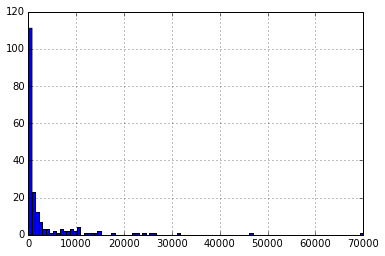

In [260]:
df.Emp.hist(bins=freedman_diaconis_rule(df.Emp))

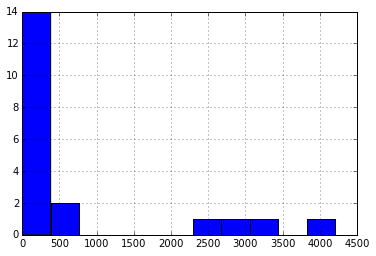

In [51]:
df.Emp.hist(bins=freedman_diaconis_rule(df.Emp))

In [36]:
other_data = pd.read_csv('/Users/drpugh/Downloads/qwi_sd_se_fa_gc_n_op_u.csv')

In [43]:
for i in range(6):
    print other_data[other_data.firmage == i].EmpTotal.describe()

count    1075872.000000
mean         367.835042
std         4486.583120
min            0.000000
25%            4.000000
50%           16.000000
75%           69.000000
max       412521.000000
Name: EmpTotal, dtype: float64
count    505950.000000
mean         41.973003
std         368.845549
min           0.000000
25%           0.000000
50%           3.000000
75%          13.000000
max       28425.000000
Name: EmpTotal, dtype: float64
count    460163.000000
mean         42.909489
std         357.803570
min           0.000000
25%           0.000000
50%           3.000000
75%          14.000000
max       25414.000000
Name: EmpTotal, dtype: float64
count    427417.000000
mean         42.181425
std         338.828830
min           0.000000
25%           0.000000
50%           3.000000
75%          15.000000
max       23910.000000
Name: EmpTotal, dtype: float64
count    578187.000000
mean         70.349595
std         637.864525
min           0.000000
25%           0.000000
50%           5.0

In [51]:
import numpy as np
import matplotlib as mpl

In [52]:
mpl.cm.jet(np.linspace(0, 1, 6))

array([[ 0.        ,  0.        ,  0.5       ,  1.        ],
       [ 0.        ,  0.3       ,  1.        ,  1.        ],
       [ 0.16129032,  1.        ,  0.80645161,  1.        ],
       [ 0.80645161,  1.        ,  0.16129032,  1.        ],
       [ 1.        ,  0.40740741,  0.        ,  1.        ],
       [ 0.5       ,  0.        ,  0.        ,  1.        ]])

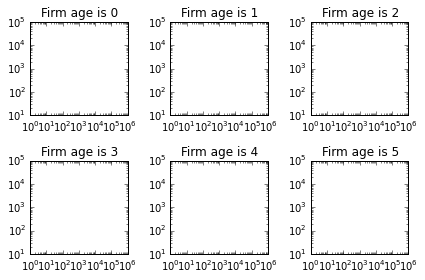

In [79]:
colors = mpl.cm.jet(mpl.cm.jet(np.linspace(0, 1, 6)))
fig, axes = plt.subplots(2, 3)
count = 0
for i in range(2):
    for j in range(3):
        tmp_df = other_data[(other_data.firmage == count) & (other_data.Emp > 0) & (other_data.industry >= "4400") & (other_data.industry < "4600")]
        axes[i, j].scatter(tmp_df.Emp, tmp_df.EarnS, facecolor='b',
                    edgecolor='b', s=3.0, alpha=0.01)
        axes[i, j].set_xlim(1e0, 1e6)
        axes[i, j].set_ylim(1e1, 1e5)
        axes[i, j].set_xscale('log')
        axes[i, j].set_yscale('log')
        axes[i, j].set_title("Firm age is {}".format(count))
        count += 1

fig.tight_layout()
plt.show()

In [83]:
other_data.ind_level.unique()

array(['A', 'S'], dtype=object)

In [75]:
(other_data.Payroll / other_data.Emp).describe()

count    3.270084e+06
mean              inf
std               NaN
min      4.000000e+00
25%      4.218333e+03
50%      7.036778e+03
75%      1.631708e+04
max               inf
dtype: float64